In [26]:
##%%
 
#####################################################
#
# APLICAR Regresión lineal a datos preprocesados con PCA
# y elegir el mejor modelo después de regularizacion
#
#####################################################
# Deben cargarse los archivos
# - T_train_final_objetivo.csv
# - T_test_final_objetivo.csv"
# - pca_pipe_num.joblib
# - pca_metadata.json
#
# Devolverá
# - reg_lin_ganador_bundle.zip
#####################################################
 
import pandas as pd
import numpy as np
import math
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
 
# === Carga de datos ===
##################################################################################################
Train = pd.read_csv("../../01_preprocessing/preprocessing/T_train_final_objetivo.csv")
Test = pd.read_csv("../../01_preprocessing/preprocessing/T_test_final_objetivo.csv")
#################################################################################################
 
X_test = Test.iloc[:, :-1]
X_train = Train.iloc[:, :-1]
y_train = Train.iloc[:, -1].to_numpy(dtype=float)
y_test = Test.iloc[:, -1].to_numpy(dtype=float)
 
SEP = "___"

In [27]:
##%%
#############################
# Funciones auxiliares
#############################
 
def is_binary_series(s: pd.Series):
    vals = pd.unique(s.dropna())
    return set(vals).issubset({0, 1}) or set(vals).issubset({0.0, 1.0})
 
 
def prefix_of(col: str, sep=SEP):
    return col.split(sep, 1)[0] if sep in col else None
 
 
def build_nominal_blocks_by_prefix(X: pd.DataFrame, sep=SEP):
    blocks = {}
    for c in X.columns:
        if sep in c and is_binary_series(X[c]):
            blocks.setdefault(prefix_of(c, sep), []).append(c)
    for k, v in blocks.items():
        blocks[k] = [c for c in X.columns if c in set(v)]
    return blocks

In [28]:
##%%
# --- Dropper (quita la base de cada bloque OHE detectado en TRAIN) ---
blocks = build_nominal_blocks_by_prefix(X_train, SEP)
drop_cols = [cols[0] for cols in blocks.values() if len(cols) >= 2]
 
arreglar_despeje = ColumnTransformer(
    transformers=[("drop_nominal_bases", "drop", drop_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )
 
arreglar_despeje.fit(X_train)

C:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,transformers,"[('drop_nominal_bases', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False


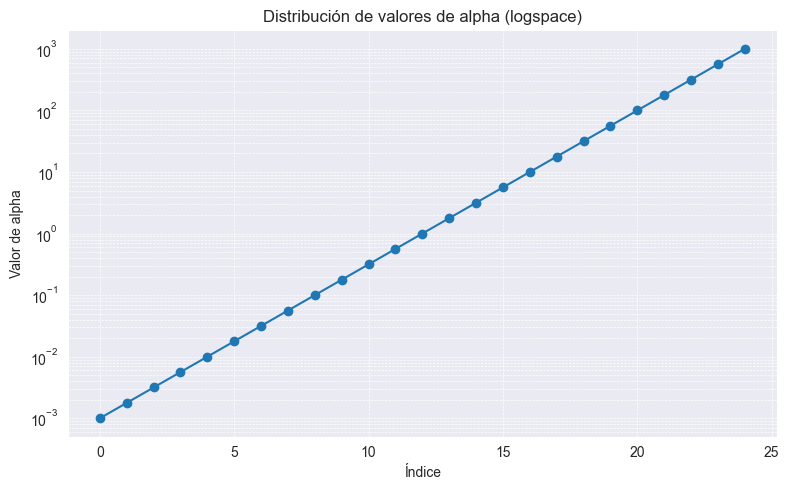

In [29]:
##%%
import numpy as np
import matplotlib.pyplot as plt
 
# Generar los valores de alpha
alphas = np.logspace(-3, 3, 25)
 
# Crear el gráfico
plt.figure(figsize=(8, 5))
plt.plot(alphas, marker='o')
plt.xscale('linear')
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Índice')
plt.ylabel('Valor de alpha')
plt.title('Distribución de valores de alpha (logspace)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [30]:
##%%
base_feats = arreglar_despeje.get_feature_names_out()
 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
 
alphas = np.logspace(-3, 3, 25)
l1_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
 
modelos = {
    "OLS": LinearRegression(),
    "Ridge": RidgeCV(alphas=alphas),
    "Lasso": LassoCV(alphas=alphas, cv=15, max_iter=5000, random_state=42),
    "ElasticNet": ElasticNetCV(l1_ratio=l1_grid, alphas=alphas, cv=15, max_iter=5000, random_state=42),
}
 
'''
Iteración 1: Entrena con [2 3 4 5], valida con [1]
Iteración 2: Entrena con [1 3 4 5], valida con [2]
Iteración 3: Entrena con [1 2 4 5], valida con [3]
Iteración 4: Entrena con [1 2 3 5], valida con [4]
Iteración 5: Entrena con [1 2 3 4], valida con [5]
'''
res = []  # métricas por modelo (en TEST) R2, RMSE
series_por_modelo = {}  # coeficientes en PRE por modelo (incluye intercepto) y Betas
params_cv = {} #alphas y l's
 
for nombre, base in modelos.items():
    # cada candidato se ajusta (fit) con el MISMO dropper ya configurado
    pipe = Pipeline([("dropper", arreglar_despeje), ("model", base)])
    pipe.fit(X_train, y_train)
 
    # ----- Métricas en TEST -----
    yhat = pipe.predict(X_test)
    r2 = r2_score(y_test, yhat)
    rmse = math.sqrt(mean_squared_error(y_test, yhat))
    mae = mean_absolute_error(y_test, yhat)
    res.append((nombre, r2, rmse, mae))
 
    # ----- Coeficientes en PRE -----
    model_step = pipe.named_steps["model"]
    # ----- Hiperparámetros seleccionados (si aplica) -----
    alpha_sel = getattr(model_step, "alpha_", getattr(model_step, "alpha", None))
    l1_sel = getattr(model_step, "l1_ratio_", getattr(model_step, "l1_ratio", None))
    params_cv[nombre] = {
        "alpha": float(alpha_sel) if alpha_sel is not None else None,
        "l1_ratio": float(l1_sel) if l1_sel is not None else None
    }
    coef = getattr(model_step, "coef_", None)
    inter = getattr(model_step, "intercept_", None)
 
    s = pd.Series(index=list(base_feats) + ["(intercepto)"], dtype=float)
    if coef is not None:
        s.loc[base_feats] = coef
    s.loc["(intercepto)"] = inter if inter is not None else np.nan
    series_por_modelo[nombre] = s
print("\nHiperparámetros por modelo:")
for k, v in params_cv.items():
    print(f"- {k}: alpha={v['alpha']}, l1_ratio={v['l1_ratio']}")

C:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_c


Hiperparámetros por modelo:
- OLS: alpha=None, l1_ratio=None
- Ridge: alpha=31.622776601683793, l1_ratio=None
- Lasso: alpha=0.001, l1_ratio=None
- ElasticNet: alpha=0.001, l1_ratio=0.1


In [31]:
##%%
# ===== Guardar métricas =====
df_res = pd.DataFrame(res, columns=["modelo", "R2", "RMSE", "MAE"])
# Criterio: R2 desc, luego RMSE asc, luego MAE asc
df_res = df_res.sort_values(by=["R2", "RMSE", "MAE"], ascending=[False, True, True])
# criterio_seleccion: R2(desc) → RMSE(asc) → MAE(asc)")
df_res.to_csv("comparacion_regularizacion.csv", index=False)
print(df_res)

       modelo        R2      RMSE       MAE
3  ElasticNet  0.302351  0.617925  0.362853
1       Ridge  0.302319  0.617939  0.362917
2       Lasso  0.302306  0.617945  0.362689
0         OLS  0.302275  0.617958  0.362981


In [32]:
##%%
# ===== Guardar coeficientes (ESPACIO PCA) =====
df_coef_ancho = pd.DataFrame(series_por_modelo)
df_coef_ancho = df_coef_ancho.reindex(columns=list(modelos.keys()))
orden_filas = ["(intercepto)"] + list(base_feats)
df_coef_ancho = df_coef_ancho.reindex(index=orden_filas)
df_coef_ancho.to_csv("coeficientes_modelos.csv", index_label="feature")
print(df_coef_ancho)
print("\nCoeficientes guardados en 'coeficientes_modelos.csv'")

                   OLS     Ridge     Lasso  ElasticNet
(intercepto)  0.576804  0.576804  0.576804    0.576804
PC1           0.148254  0.148233  0.148021    0.148200
PC2           0.067779  0.067744  0.066913    0.067640
PC3           0.041576  0.041554  0.040692    0.041454
PC4          -0.010801 -0.010794 -0.009643   -0.010674
PC5          -0.355067 -0.354576 -0.352768   -0.354104
PC6          -0.264121 -0.262327 -0.252768   -0.260326
PC7          -0.322220 -0.313445 -0.275739   -0.304821
PC8          -0.243358 -0.232031 -0.162313   -0.219261

Coeficientes guardados en 'coeficientes_modelos.csv'


In [33]:
##%%
#####################################################
# Selección del mejor modelo + veredicto (en TEST)
#####################################################
 
# df_res ya fue creado y ordenado por: R2(desc) → RMSE(asc) → MAE(asc)
 
best_row = df_res.iloc[0]
best_name = str(best_row["modelo"])
 
r2_best = float(best_row["R2"])
rmse_best = float(best_row["RMSE"])
mae_best = float(best_row["MAE"])
 
# NRMSE respecto a la desviación estándar de y_test
std_y_test = float(np.std(y_test, ddof=0))
nrmse_best = rmse_best / (std_y_test + 1e-12)
 
# Semáforo
verde = (r2_best >= 0.70) and (nrmse_best <= 0.50)
amarillo = (0.40 <= r2_best < 0.70) or (0.50 < nrmse_best <= 0.80)
if verde:
    veredicto = "VERDE"
    significado = "confiable para predecir aquí dentro."
elif amarillo:
    veredicto = "AMARILLO"
    significado = "usable con cautela (depende del caso de uso)"
else:
    veredicto = "ROJO"
    significado = "no confiable para predicción aquí dentro"
 
print("\n================  RESULTADOS EN TEST  ================")
print(f"🏆 MODELO GANADOR: {best_name}")
print(f"R² = {r2_best:.4f} | RMSE = {rmse_best:.6f} | MAE = {mae_best:.6f} | NRMSE = {nrmse_best:.4f}")
print(f"Veredicto: {veredicto} — {significado}")
 
beta_ganador = df_coef_ancho[[best_name]].copy()
beta_ganador.columns = [f"beta_{best_name}"]
print("\n================  COEFICIENTES DEL MODELO GANADOR  ================")
print(beta_ganador.to_string())


================  RESULTADOS EN TEST  ================
🏆 MODELO GANADOR: ElasticNet
R² = 0.3024 | RMSE = 0.617925 | MAE = 0.362853 | NRMSE = 0.8353
Veredicto: ROJO — no confiable para predicción aquí dentro

================  COEFICIENTES DEL MODELO GANADOR  ================
              beta_ElasticNet
(intercepto)         0.576804
PC1                  0.148200
PC2                  0.067640
PC3                  0.041454
PC4                 -0.010674
PC5                 -0.354104
PC6                 -0.260326
PC7                 -0.304821
PC8                 -0.219261


In [34]:
##%%
#####################################################
# Betas en ESPACIO POST-PRE (numéricas antes de std_for_pca y PCA)
# Usa el modelo GANADOR (best_name) y artefactos de PCA_full
#####################################################
import joblib, json
 
# 1) Extraer del ganador sus coeficientes de PCs y el intercepto (desde df_coef_ancho)
pc_prefix = "PC"
beta_col = df_coef_ancho[best_name]
 
# Orden estricto de PCs (PC1, PC2, ..., según aparezcan en df_coef_ancho)
pc_index = [idx for idx in df_coef_ancho.index if isinstance(idx, str) and idx.startswith(pc_prefix)]
beta_PC = beta_col.loc[pc_index].to_numpy(dtype=float)  # (k,)
beta0_PC = float(beta_col.loc["(intercepto)"])  # intercepto en espacio PC
 
# 2) Cargar el pipeline numérico usado en PCA_full
#######################################################################################
pca_pipe = joblib.load("../../01_preprocessing/preprocessing/pca_pipe_num.joblib")
#######################################################################################
pca = pca_pipe.named_steps["pca"]  # PCA(n_components=k)
scaler = pca_pipe.named_steps["std_for_pca"]  # StandardScaler
pre = pca_pipe.named_steps["pre"]  # ColumnTransformer (pre numérico)
 
# 3) Extraer matrices/vectores necesarios
C = pca.components_  # (k, p)  filas=PCs, cols=features numéricas "post-pre"
mu = scaler.mean_.astype(float)  # (p,)
sig = scaler.scale_.astype(float)  # (p,)
pre_feature_names = pre.get_feature_names_out()  # nombres numéricos "post-pre" (longitud p)
 
# 4) Back-transform: PCs -> estandarizadas -> post-pre
#    gamma = C^T * beta_PC    # coeficientes respecto a variables estandarizadas por std_for_pca
gamma = C.T @ beta_PC  # (p,)
alpha_pre = gamma / sig  # (p,) betas en variables numéricas post-pre
beta0_pre = beta0_PC - np.sum(gamma * (mu / sig))  # intercepto en post-pre
 
# 5) Empaquetar resultados en el orden de 'pre_feature_names'
betas_post_pre_df = pd.DataFrame({
    "feature_post_pre": pre_feature_names,
    "beta_post_pre": alpha_pre
})
#####################################################################################################
with open("../../01_preprocessing/preprocessing/pca_metadata.json", "r", encoding="utf-8") as f:
#####################################################################################################
    meta = json.load(f)
 
orden_original_num = meta.get("cols_num", list(pre_feature_names))
presentes = set(betas_post_pre_df["feature_post_pre"].tolist())
orden_final = [c for c in orden_original_num if c in presentes]
 
betas_post_pre_df = (
    betas_post_pre_df
    .set_index("feature_post_pre")
    .loc[orden_final]
    .reset_index()
)
 
# Guardar a CSV
betas_post_pre_df.to_csv("betas_post_pre_numericas.csv", index=False)
intercept_row = pd.DataFrame({
    "feature_post_pre": ["(intercepto)"],
    "beta_post_pre": [beta0_pre]
})
betas_post_pre_df = pd.concat([intercept_row, betas_post_pre_df], ignore_index=True)
 
print("\n================  COEFICIENTES NUMÉRICOS (ESPACIO POST-PRE)  ================")
print(betas_post_pre_df.to_string(index=False))
 
# 8) Guardar a CSV
betas_post_pre_df.to_csv("betas_post_pre_numericas.csv", index=False)
print("\nBetas numéricas (post-pre) guardadas en 'betas_post_pre_numericas.csv' (incluye intercepto).")
 


================  COEFICIENTES NUMÉRICOS (ESPACIO POST-PRE)  ================
feature_post_pre  beta_post_pre
    (intercepto)       0.680042
           alpha       0.008750
           delta       0.023801
               u      -0.069322
               g      -0.274486
               r       0.021614
               i       0.498010
               z       0.122373
           class      -0.330842

Betas numéricas (post-pre) guardadas en 'betas_post_pre_numericas.csv' (incluye intercepto).


In [35]:
##%%
############################################################
# Selección y guardado del mejor modelo
############################################################
 
import joblib, json, time, os, zipfile, io
 
best_row = df_res.loc[df_res["R2"].idxmax()]
best_name = best_row["modelo"]
print(f"🏆 MODELO GANADOR: {best_name}\n", best_row)
 
best_estimator = modelos[best_name]
best_pipeline = Pipeline([("dropper", arreglar_despeje), ("model", best_estimator)])
best_pipeline.fit(X_train, y_train)
 
buf = io.BytesIO()
joblib.dump(best_pipeline, buf)
buf.seek(0)
 
metadata = {
    "modelo_ganador": best_name,
    "R2_test": float(best_row["R2"]),
    "RMSE_test": float(best_row["RMSE"]),
    "MAE_test": float(best_row["MAE"]),
    "columnas_esperadas": X_train.columns.tolist(),
    "fecha_guardado": time.strftime("%Y-%m-%d %H:%M:%S")
}
meta_str = json.dumps(metadata, indent=2, ensure_ascii=False)
 
# --- Crear ZIP con todo adentro ---
dst_dir = "reg_lin_ganador"
os.makedirs(dst_dir, exist_ok=True)
zip_path = os.path.join(dst_dir, "reg_lin_ganador_bundle.zip")
 
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr(f"modelo_{best_name.lower()}.pkl", buf.getvalue())
    zf.writestr("metadata_modelo.json", meta_str)
 
print(f"✅ Bundle creado en: {zip_path}")
print("Contiene: [modelo_*.pkl, metadata_modelo.json]")

🏆 MODELO GANADOR: ElasticNet
 modelo    ElasticNet
R2          0.302351
RMSE        0.617925
MAE         0.362853
Name: 3, dtype: object


C:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Bundle creado en: reg_lin_ganador\reg_lin_ganador_bundle.zip
Contiene: [modelo_*.pkl, metadata_modelo.json]
